<a href="https://colab.research.google.com/github/roshank1605A04/Credit-Card-Fraud-Detection/blob/master/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking for missing values: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  690 non-null    int64  
 1   A1          690 non-null    int64  
 2   A2          690 non-null    float64
 3   A3          690 non-null    float64
 4   A4          690 non-null    int64  
 5   A5          690 non-null    int64  
 6   A6          690 non-null    int64  
 7   A7          690 non-null    float64
 8   A8          690 non-null    int64  
 9   A9          690 non-null    int64  
 10  A10         690 non-null    int64  
 11  A11         690 non-null    int64  
 12  A12         690 non-null    int64  
 13  A13         690 non-null    int64  
 14  A14         690 non-null    int64  
 15  Class       690 non-null    int64  
dtypes: float64(3), int64(13)
memory usage: 86.4 KB
None
         CustomerID          A1          A2          A3          

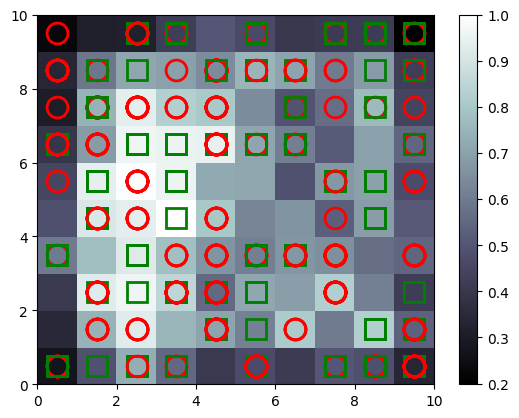

Epoch 1/2


c:\Users\jayas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.9823 - loss: 0.6741
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.9880 - loss: 0.5670


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predictions (Customer ID and Fraud Probability):
[[1.56214230e+07 1.77354544e-01]
 [1.57997850e+07 1.86866716e-01]
 [1.56548590e+07 2.19522864e-01]
 ...
 [1.56864610e+07 4.34373289e-01]
 [1.57845260e+07 4.34892297e-01]
 [1.55695950e+07 4.49184060e-01]]


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show

# Load the dataset
data = pd.read_csv(r"C:\Users\jayas\Downloads\Credit-Card-Fraud-Detection-master\Credit-Card-Fraud-Detection-master\Credit_Card_Applications.csv")

# Splitting data into independent (X) and dependent (y) variables
X = data.iloc[:, :-1].values  # All columns except the last one
y = data.iloc[:, -1].values   # Last column (class labels)

# Data overview
print("Checking for missing values:", data.isnull().any().any())
print(data.info())
print(data.describe())

# Scale features for SOM
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Initialize and train the SOM
som = MiniSom(x=10, y=10, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_scaled)
som.train_random(data=X_scaled, num_iteration=100)

# Visualizing the SOM results
bone()
pcolor(som.distance_map().T)  # Distance map as a heatmap
colorbar()
markers = ['o', 's']  # Markers for different classes
colors = ['r', 'g']   # Colors for different classes

# Mark the nodes
for i, sample in enumerate(X_scaled):
    winner = som.winner(sample)  # Get the winning node
    plot(
        winner[0] + 0.5,
        winner[1] + 0.5,
        markers[y[i]],
        markeredgecolor=colors[y[i]],
        markerfacecolor='None',
        markersize=15,
        markeredgewidth=2,
    )
show()

# Find frauds based on SOM mappings
mappings = som.win_map(X_scaled)
fraud_positions = [(2, 4), (7, 4)]  # Define positions for potential fraud
frauds = np.concatenate([mappings[pos] for pos in fraud_positions if pos in mappings], axis=0) if fraud_positions else np.array([])

# Check and inverse transform frauds
if frauds.size > 0:
    frauds = scaler.inverse_transform(frauds)  # Convert scaled values back to original scale
else:
    print("No frauds detected in the specified SOM grid positions.")

# Creating the feature matrix and labels for neural network
customers = data.iloc[:, 1:].values
is_fraud = np.zeros(len(data))
if frauds.size > 0:
    is_fraud[data.iloc[:, 0].isin(frauds[:, 0]).values] = 1  # Mark customers as fraud if their ID matches

# Scale features for the neural network
nn_scaler = StandardScaler()
customers_scaled = nn_scaler.fit_transform(customers)

# Build the neural network
model = Sequential()
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu', input_dim=customers_scaled.shape[1]))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(customers_scaled, is_fraud, batch_size=10, epochs=2)

# Save the model
model.save('Credit_Card_Fraud_Model.h5')

# Reload the model for predictions
model = load_model('Credit_Card_Fraud_Model.h5')

# Predict fraud probabilities
y_pred = model.predict(customers_scaled)
predictions = np.concatenate((data.iloc[:, 0:1].values, y_pred), axis=1)  # Add customer IDs
predictions = predictions[predictions[:, 1].argsort()]  # Sort by fraud probability

# Display the predictions
print("Predictions (Customer ID and Fraud Probability):")
print(predictions)


<a href="https://colab.research.google.com/github/roshank1605A04/Credit-Card-Fraud-Detection/blob/master/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
X.shape  # This will show you the number of features your model expects


(690, 15)

In [50]:
import pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(nn_scaler, file)
